In [1]:
%matplotlib inline
import operator

import numpy as np
import pandas as pd
import networkx as nx

from scipy.stats import pearsonr
from itertools import product
from itertools import combinations
from itertools import permutations

import matplotlib.pyplot as plt

**Toy-Example**:<br />
Random network G=(N,p)<br />
Binary node-attribute: color

In [2]:
N=20
p=0.4
attribute = 'color'
G = nx.erdos_renyi_graph(n=N,p=p)
nx.set_node_attributes(G, name=attribute, values={i:np.random.choice([0,1]) for i in G.nodes()})
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 20
Number of edges: 63
Average degree:   6.3000


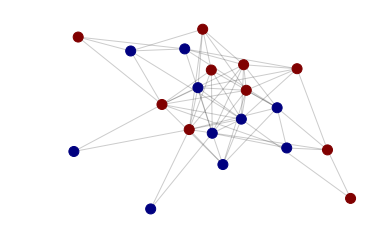

In [3]:
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G, pos, 
                            nodelist=G.nodes(), 
                            node_color=[data[attribute] for n,data in G.nodes(data=True)], 
                            with_labels=False, 
                            node_size=100, 
                            cmap=plt.cm.jet)
plt.axis('off')
plt.show()

***Pearson Correlation Coefficient***

Implemented from scratch

In [4]:
def correlation(e):
    numerator = sum([(j*k)*(e.loc[j,k]-(e.loc[j,:].sum()*e.loc[:,k].sum())) for j,k in product(e.index,e.columns)])
    denominator_j = sum([(j**2)*e.loc[j,:].sum() for j in e.index]) - (sum([j*e.loc[j,:].sum() for j in e.index]))**2
    denominator_k = sum([(k**2)*e.loc[:,k].sum() for k in e.columns]) - (sum([k*e.loc[:,k].sum() for k in e.columns]))**2
    return numerator / np.sqrt(denominator_j*denominator_k)

***Assortativity Coefficient***

Implemented from scratch following:

*Mixing patterns in networks by M. E. J. Newman*

https://arxiv.org/pdf/cond-mat/0209450.pdf

In [5]:
# https://arxiv.org/pdf/cond-mat/0209450.pdf
# Mixing patterns in networks. M. E. J. Newman
def assortativity_coef(G):
    # https://www.nature.com/articles/srep15450
    # eq. 4
    Ne = float(G.number_of_edges())
    num_1 = sum([G.degree(e[0])*G.degree(e[1]) for e in G.edges()]) / Ne
    num_2 = (sum([ (1/2)*(G.degree(e[0])+G.degree(e[1])) for e in G.edges()] ) / Ne)**2
    den_1 = sum([(1/2) * (G.degree(e[0])**2 + G.degree(e[1])**2) for e in G.edges() ]) / Ne
    den_2 = num_2
    return (num_1-num_2)/(den_1-den_2)

***Degree-Degree Correlation***

In [6]:
def degree_correlation_matrix(G):
    pairs = [(G.degree(edge[0]),G.degree(edge[1])) for edge in G.edges()]
    
    if not G.is_directed():
        pairs.extend([(b,a) for a,b in pairs])
        
    index = list(zip(*pairs))
    index = sorted(set(index[0])|set(index[1]))
    
    df = pd.DataFrame(index=index,columns=index)
    df.fillna(0,inplace=True)
    for p in pairs:
        df.loc[p[0],p[1]] += 1
    df /= df.values.sum()
    return df

In [7]:
e=degree_correlation_matrix(G)
e

,2,3,4,5,6,7,8,9,10,11
2,0.000000,0.000000,0.000000,0.007937,0.000000,0.000000,0.000000,0.007937,0.023810,0.007937
3,0.000000,0.000000,0.000000,0.007937,0.007937,0.000000,0.000000,0.000000,0.007937,0.000000
4,0.000000,0.000000,0.000000,0.007937,0.000000,0.000000,0.007937,0.007937,0.007937,0.000000
5,0.007937,0.007937,0.007937,0.000000,0.023810,0.000000,0.007937,0.000000,0.015873,0.007937
6,0.000000,0.007937,0.000000,0.023810,0.031746,0.015873,0.023810,0.071429,0.039683,0.023810
7,0.000000,0.000000,0.000000,0.000000,0.015873,0.000000,0.000000,0.015873,0.015873,0.007937
8,0.000000,0.000000,0.007937,0.007937,0.023810,0.000000,0.000000,0.015873,0.007937,0.000000
9,0.007937,0.000000,0.007937,0.000000,0.071429,0.015873,0.015873,0.047619,0.023810,0.023810
10,0.023810,0.007937,0.007937,0.015873,0.039683,0.015873,0.007937,0.023810,0.000000,0.015873
11,0.007937,0.000000,0.000000,0.007937,0.023810,0.007937,0.000000,0.023810,0.015873,0.000000


In [8]:
correlation(e)

-0.18579397862283245

In [9]:
pairs = [(G.degree(e[0]),G.degree(e[1])) for e in G.edges()]
if not G.is_directed():
    pairs.extend([(b,a) for a,b in pairs])
v1,v2=zip(*pairs)
pearsonr(v1,v2)

(-0.18579397862283356, 0.037258593420040537)

In [10]:
nx.degree_assortativity_coefficient(G)

-0.18579397862283248

In [11]:
assortativity_coef(G)

-0.18579397862283334

***Attribute-Attribute Correlation***

In [12]:
def attribute_correlation_matrix(G, attribute):
    node_attributes = nx.get_node_attributes(G=G, name=attribute)
    if not node_attributes:
        raise Exception('attribute \'{}\' does not exist.'.format(attribute))
        
    pairs = [(G.node[edge[0]][attribute],G.node[edge[1]][attribute]) for edge in G.edges()]
    
    if not G.is_directed():
        pairs.extend([(b,a) for a,b in pairs])
    
    index = sorted(set(node_attributes.values()))

    df = pd.DataFrame(index=index,columns=index)
    df.fillna(0,inplace=True)
    for p in pairs:
        df.loc[p[0],p[1]] += 1
    df /= df.values.sum()
    return df

In [13]:
e=attribute_correlation_matrix(G,attribute)
correlation(e)

-0.081818181818181457

In [14]:
pairs = [(G.node[e[0]][attribute],G.node[e[1]][attribute]) for e in G.edges()]
if not G.is_directed():
    pairs.extend([(b,a) for a,b in pairs])
v1,v2=zip(*pairs)
pearsonr(v1,v2)

(-0.081818181818181859, 0.36241026353745431)

In [15]:
nx.attribute_assortativity_coefficient(G,attribute)

-0.08181818181818179

***Degree-Attribute Correlation***

In [16]:
def degree_attribute_correlation_matrix(G, attribute):
    node_attributes = nx.get_node_attributes(G=G, name=attribute)
    if not node_attributes:
        raise Exception('attribute \'{}\' does not exist.'.format(attribute))
        
    pairs = [(G.degree(n),G.node[n][attribute]) for n in G.nodes()]
    index, columns = zip(*pairs)
    
    index = sorted(set(index))
    columns = sorted(set(columns))
    
    df = pd.DataFrame(index=index,columns=columns)
    df.fillna(0,inplace=True)
    for p in pairs:
        df.loc[p[0],p[1]] += 1
    df /= df.values.sum()
    return df

In [17]:
e=degree_attribute_correlation_matrix(G,attribute)
e

,0,1
2,0.10,0.05
3,0.00,0.05
4,0.05,0.00
5,0.05,0.05
6,0.10,0.15
7,0.05,0.00
8,0.05,0.00
9,0.05,0.10
10,0.00,0.10
11,0.05,0.00


In [18]:
correlation(e)

0.10947155477532391

In [19]:
v1,v2=zip(*[(G.degree(n),G.node[n][attribute]) for n in G.nodes()])
pearsonr(v1,v2)

(0.10947155477532401, 0.6459228826148653)

***Degree-Degree Monophily Correlation***

In [20]:
def degree_monophily_correlation_matrix(G):
    pairs = [(G.degree(j),G.degree(k)) for i in G.nodes() for (j,k) in permutations(G.neighbors(i),2)]
 
    index = list(zip(*pairs))
    index = sorted(set(index[0])|set(index[1]))
    
    df = pd.DataFrame(index=index,columns=index)
    df.fillna(0,inplace=True)
    for p in pairs:
        df.loc[p[0],p[1]] += 1
    df /= df.values.sum()
    return df

In [21]:
e=degree_monophily_correlation_matrix(G)
e

,2,3,4,5,6,7,8,9,10,11
2,0.002445,0.001222,0.003667,0.004890,0.018337,0.006112,0.003667,0.011002,0.003667,0.004890
3,0.001222,0.000000,0.001222,0.002445,0.006112,0.001222,0.001222,0.004890,0.001222,0.002445
4,0.003667,0.001222,0.000000,0.002445,0.011002,0.002445,0.001222,0.007335,0.002445,0.002445
5,0.004890,0.002445,0.002445,0.000000,0.018337,0.006112,0.003667,0.018337,0.007335,0.004890
6,0.018337,0.006112,0.011002,0.018337,0.051345,0.019560,0.014670,0.062347,0.035452,0.024450
7,0.006112,0.001222,0.002445,0.006112,0.019560,0.000000,0.002445,0.017115,0.004890,0.006112
8,0.003667,0.001222,0.001222,0.003667,0.014670,0.002445,0.000000,0.013447,0.011002,0.006112
9,0.011002,0.004890,0.007335,0.018337,0.062347,0.017115,0.013447,0.031785,0.034230,0.019560
10,0.003667,0.001222,0.002445,0.007335,0.035452,0.004890,0.011002,0.034230,0.014670,0.012225
11,0.004890,0.002445,0.002445,0.004890,0.024450,0.006112,0.006112,0.019560,0.012225,0.000000


In [22]:
correlation(e)

0.034794077595335739

In [23]:
v1,v2 = zip(*[(G.degree(j),G.degree(k)) for i in G.nodes() for (j,k) in permutations(G.neighbors(i),2)])
pearsonr(v1,v2)

(0.034794077595335565, 0.32026466525432784)

***Attribute-Attribute Monophily correlation***

In [24]:
def attribute_monophily_correlation_matrix(G, attribute):
    node_attributes = nx.get_node_attributes(G=G, name=attribute)
    if not node_attributes:
        raise Exception('attribute \'{}\' does not exist.'.format(attribute))
        
    pairs = [(G.node[j][attribute],G.node[k][attribute]) for i in G.nodes() for (j,k) in permutations(G.neighbors(i),2)]
    index = sorted(set(node_attributes.values()))

    df = pd.DataFrame(index=index,columns=index)
    df.fillna(0,inplace=True)
    for p in pairs:
        df.loc[p[0],p[1]] += 1
    df /= df.values.sum()
    return df

In [25]:
e=attribute_monophily_correlation_matrix(G,attribute)
e

,0,1
0,0.215159,0.272616
1,0.272616,0.239609


In [26]:
correlation(e)

-0.091116813513497402

In [27]:
v1,v2 = zip(*[(G.node[j][attribute],G.node[k][attribute]) for i in G.nodes() for (j,k) in permutations(G.neighbors(i),2)])
pearsonr(v1,v2)

(-0.091116813513497319, 0.0091220684267851772)